# Assignment 8: Correlation Analysis and Hypothesis Testing

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and hypothesis testing, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

**Correlation Analysis**
1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 


**Hypothesis Testing**
1. Why A/B testing?  
2. What is a permutation test? How to implement it?
3. What is p-value? How to avoid p-hacking? 
4. What is a chi-squared test? How to implement it?


In this assignment, you can use [pandas](https://pandas.pydata.org/) or PySpark to manipulate data, and use [matplotlib](https://matplotlib.org/) or [seaborn](seaborn.pydata.org) to make plots. 

## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a dataset from [property_tax_report_2018.zip](property_tax_report_2018.zip). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2018.  You can find the schema information of the dataset from this [webpage](http://data.vancouver.ca/datacatalogue/propertyTaxAttributes.htm). 

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [4]:
import pandas as pd

df = pd.read_csv("data/property_tax_report_2018.csv")

df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE']+x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)
df.head()

,PID,LEGAL_TYPE,FOLIO,LAND_COORDINATE,ZONE_NAME,ZONE_CATEGORY,LOT,BLOCK,PLAN,DISTRICT_LOT,...,CURRENT_LAND_VALUE,CURRENT_IMPROVEMENT_VALUE,TAX_ASSESSMENT_YEAR,PREVIOUS_LAND_VALUE,PREVIOUS_IMPROVEMENT_VALUE,YEAR_BUILT,BIG_IMPROVEMENT_YEAR,TAX_LEVY,NEIGHBOURHOOD_CODE,HOUSE_PRICE
0,025-734-601,STRATA,7.500400e+11,75004024,C-2,Commercial,25,NaN,BCS498,2027,...,592000,242000,2018,472000.0,238000.0,2003.0,2003.0,NaN,3,0.834
1,029-700-868,STRATA,6.381830e+11,63818250,CD-1 (464),Comprehensive Development,132,NaN,EPS2983,200A,...,715000,327000,2018,603000.0,329000.0,NaN,NaN,NaN,13,1.042
2,029-814-227,STRATA,1.708260e+11,17082596,CD-1 (535),Comprehensive Development,25,NaN,EPS3173,311,...,507000,273000,2018,416000.0,273000.0,NaN,NaN,NaN,12,0.780
3,029-918-731,STRATA,6.401940e+11,64019406,IC-3,Light Industrial,40,26,EPS2425,200A,...,227000,170000,2018,168000.0,170000.0,NaN,NaN,NaN,13,0.397
4,017-393-400,STRATA,6.011150e+11,60111496,CD-1 (233),Comprehensive Development,7,NaN,LMS75,185,...,801000,380000,2018,531000.0,385000.0,1991.0,1991.0,NaN,27,1.181


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205346 entries, 0 to 205345
Data columns (total 29 columns):
PID                           204809 non-null object
LEGAL_TYPE                    205346 non-null object
FOLIO                         205346 non-null float64
LAND_COORDINATE               205346 non-null int64
ZONE_NAME                     205343 non-null object
ZONE_CATEGORY                 203502 non-null object
LOT                           203960 non-null object
BLOCK                         86376 non-null object
PLAN                          205143 non-null object
DISTRICT_LOT                  190379 non-null object
FROM_CIVIC_NUMBER             99336 non-null object
TO_CIVIC_NUMBER               204731 non-null float64
STREET_NAME                   205150 non-null object
PROPERTY_POSTAL_CODE          201545 non-null object
NARRATIVE_LEGAL_LINE1         205247 non-null object
NARRATIVE_LEGAL_LINE2         205173 non-null object
NARRATIVE_LEGAL_LINE3         140646 non-n

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose <font color='blue'>postcode starts with 'V6A'</font>. Furthermore, we remove the houses that were <font color='blue'>built before 1900</font>.

In [17]:
df_v6a = df[df['PROPERTY_POSTAL_CODE'].map(lambda x: True if str(x).strip().startswith("V6A") else False)]
df_modern = df_v6a[df_v6a['YEAR_BUILT']>1900]
df_modern.head()

,PID,LEGAL_TYPE,FOLIO,LAND_COORDINATE,ZONE_NAME,ZONE_CATEGORY,LOT,BLOCK,PLAN,DISTRICT_LOT,...,CURRENT_LAND_VALUE,CURRENT_IMPROVEMENT_VALUE,TAX_ASSESSMENT_YEAR,PREVIOUS_LAND_VALUE,PREVIOUS_IMPROVEMENT_VALUE,YEAR_BUILT,BIG_IMPROVEMENT_YEAR,TAX_LEVY,NEIGHBOURHOOD_CODE,HOUSE_PRICE
577,009-785-931,STRATA,5.922120e+11,59221204,RT-3,Two Family Dwelling,3,NaN,VAS2071,181,...,1046000,131000,2018,1004000.0,135000.0,1987.0,1987.0,NaN,13,1.1770
612,004-207-882,LAND,1.905790e+11,19057935,DEOD,Comprehensive Development,4,3,VAP184,196,...,1229000,713000,2018,1124000.0,552400.0,1908.0,1908.0,NaN,26,1.9420
745,003-879-607,STRATA,5.941980e+11,59419848,RT-3,Two Family Dwelling,C,NaN,VAS328,196,...,690000,68600,2018,584000.0,74500.0,1975.0,1975.0,NaN,13,0.7586
774,011-906-219,LAND,5.802060e+11,58020574,M-2,Industrial,15,51,VAP196,181,...,1428000,4500,2018,1066000.0,4500.0,1978.0,1978.0,NaN,13,1.4325
778,008-013-225,LAND,5.981990e+11,59819870,RT-3,Two Family Dwelling,15,101,VAP196,196,...,1493000,116000,2018,1349000.0,121000.0,1905.0,1965.0,NaN,13,1.6090


<img src="img/v6a.png", width=500/>

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

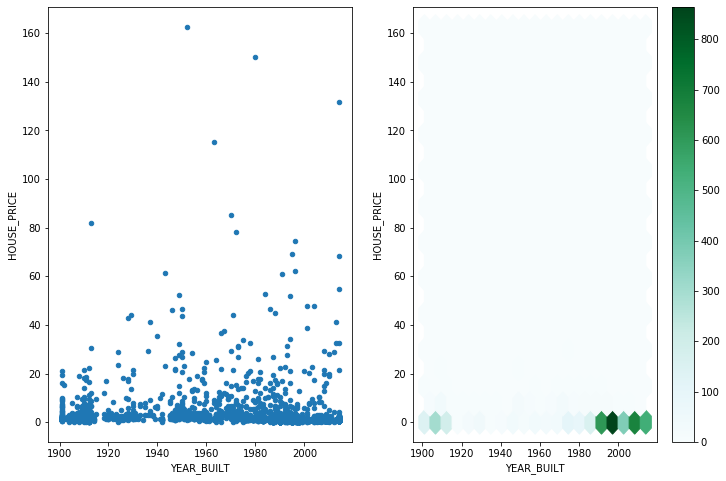

In [23]:
#<-- Write Your Code -->
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(1, 2, figsize=(12, 8))
ax1 = df_modern.plot.scatter(x='YEAR_BUILT',y='HOUSE_PRICE',ax=axarr[0])
ax2 = df_modern.plot.hexbin(x='YEAR_BUILT',y='HOUSE_PRICE',gridsize=20,ax=axarr[1])
plt.show()

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. The number of expensive houses went up after the year 1980. 
2. Years around 1940 saw the least overall real estate prices for the total duration considered.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insight. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


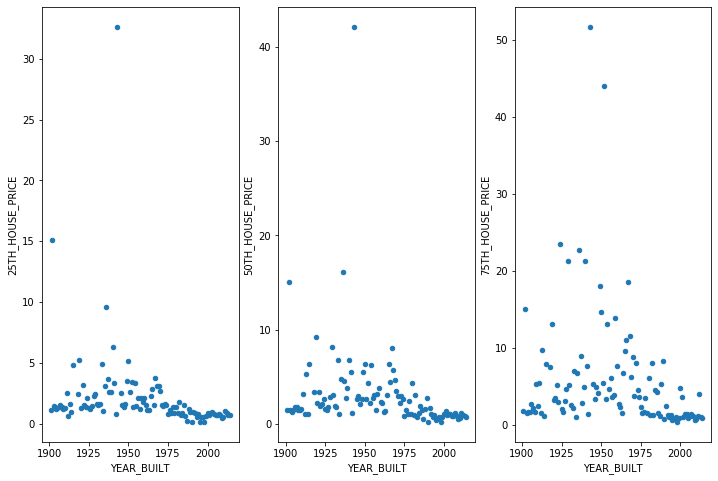

In [51]:
#<-- Write Your Code -->
import numpy as np

df_new = pd.DataFrame()
df_quantile = df_modern[['YEAR_BUILT','HOUSE_PRICE']].groupby(['YEAR_BUILT'])
df_new["25TH_HOUSE_PRICE"] = df_quantile.apply(lambda x: np.percentile(x['HOUSE_PRICE'],q=25))
df_new["50TH_HOUSE_PRICE"] = df_quantile.apply(lambda x: np.percentile(x['HOUSE_PRICE'],q=50))
df_new["75TH_HOUSE_PRICE"] = df_quantile.apply(lambda x: np.percentile(x['HOUSE_PRICE'],q=75))
df_new["YEAR_BUILT"] = df_quantile.apply(lambda x: int(x.name))

#PLOTS 
fig, axarr = plt.subplots(1, 3, figsize=(12, 8))
ax1 = df_new.plot.scatter(x='YEAR_BUILT',y='25TH_HOUSE_PRICE',ax=axarr[0])
ax2 = df_new.plot.scatter(x='YEAR_BUILT',y='50TH_HOUSE_PRICE',ax=axarr[1])
ax3 = df_new.plot.scatter(x='YEAR_BUILT',y='75TH_HOUSE_PRICE',ax=axarr[2])
plt.show()

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. As the house price percentile increases, the range of prices increases for subsequent years.  
2. Majority of houses have prices in all three percentiles between the range 0-10, indicating a very small variation in prices for maximum households (for every corresponding year). 

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>, and then print out your results. 

Note that it is OK to use this [function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to do this task, but make sure that you understand how the numbers are computed. 

In [54]:
#<-- Write Your Code -->
cols = ['25TH_HOUSE_PRICE', '50TH_HOUSE_PRICE', '75TH_HOUSE_PRICE']
main_col = 'YEAR_BUILT'
for i in cols:
    df_corr_pearson = df_new[[i,main_col]].corr(method='pearson')
    df_corr_spearman = df_new[[i,main_col]].corr(method='spearman')
    print("PEARSON CORRELATION BETWEEN {} and {}:\n".format(i,main_col))
    print(df_corr_pearson)
    print("SPEARMAN CORRELATION BETWEEN {} and {}:\n".format(i,main_col))
    print(df_corr_spearman)

PEARSON CORRELATION BETWEEN 25TH_HOUSE_PRICE and YEAR_BUILT:

                  25TH_HOUSE_PRICE  YEAR_BUILT
25TH_HOUSE_PRICE          1.000000   -0.250809
YEAR_BUILT               -0.250809    1.000000
SPEARMAN CORRELATION BETWEEN 25TH_HOUSE_PRICE and YEAR_BUILT:

                  25TH_HOUSE_PRICE  YEAR_BUILT
25TH_HOUSE_PRICE           1.00000    -0.57736
YEAR_BUILT                -0.57736     1.00000
PEARSON CORRELATION BETWEEN 50TH_HOUSE_PRICE and YEAR_BUILT:

                  50TH_HOUSE_PRICE  YEAR_BUILT
50TH_HOUSE_PRICE          1.000000   -0.245879
YEAR_BUILT               -0.245879    1.000000
SPEARMAN CORRELATION BETWEEN 50TH_HOUSE_PRICE and YEAR_BUILT:

                  50TH_HOUSE_PRICE  YEAR_BUILT
50TH_HOUSE_PRICE          1.000000   -0.519268
YEAR_BUILT               -0.519268    1.000000
PEARSON CORRELATION BETWEEN 75TH_HOUSE_PRICE and YEAR_BUILT:

                  75TH_HOUSE_PRICE  YEAR_BUILT
75TH_HOUSE_PRICE          1.000000   -0.223003
YEAR_BUILT               -0.22

Please write down the **two** most interesting findings that you draw from the result. 

**Findings**
1. Based on the pearson correlation between the percentiles, the values vary non-linearly with YEAR_BUILT. That is, with every increasing year the values tend to decrease non-linearly. 
2. Similarly, based on spearman's correlation, the values are non-monotonically decreasing with respect to increase in yearly values. 

## Part 2. Hypothesis Testing

In many situations, we cannot get the full population but only a sample. If we derive an interesting result from a sample, how likely can we derive the same result from the entire population? In other words, we want to know whether this result is a true finding or it just happens in the sample by chance. Hypothesis testing aims to answer this fundamental question. 

### Task C. A/B Testing
> Acknowledgment: Thank [Greg Baker](http://www.cs.sfu.ca/~ggbaker/) for helping me to prepare this task.

A very common technique to evaluate changes in a user interface is A/B testing: show some users interface A, some interface B, and then look to see if one performs better than the other.

Suppose I started an A/B test on CourSys. Here are the two interfaces that I want to compare with. I want to know whether a good placeholder in the search box can attract more users to use the `search` feature.


![](img/ab-testing.png)

The provided [searchlog.json](./searchlog.json) has information about users' usage. The question I was interested in: is the number of searches per user different?

To answer this question, we need to first pick up a **test statistic** to quantify how good an interface is. Here, we choose "the search_count mean". 

Please write the code to compute **the difference of the search_count means between interface A and Interface B.** 

In [65]:
source = "data/searchlog.json"
df_search = pd.read_json(source,lines=True)
df_search.head()

,is_instructor,search_count,search_ui,uid
0,True,2,A,6061521
1,False,0,A,11986457
2,False,0,A,15995765
3,True,0,B,9106912
4,False,0,A,9882383


In [66]:
#<-- Write Your Code -->
df_search_A = df_search[df_search['search_ui']=='A']['search_count']
df_search_B = df_search[df_search['search_ui']=='B']['search_count']
print(abs(df_search_A.mean()-df_search_B.mean()))

0.13500569535052287


Suppose we find that the mean value increased by 0.135. Then, we wonder whether this result is just caused by random variation. 

We define the Null Hypothesis as
 * The difference in search_count mean between Interface A and Interface B is caused by random variation. 
 
Then the next job is to check whether we can reject the null hypothesis or not. If it does, we can adopt the alternative explanation:
 * The difference in search_count mean  between Interface A and Interface B is caused by the design differences between the two.

We compute the p-value of the observed result. If p-value is low (e.g., <0.01), we can reject the null hypothesis, and adopt  the alternative explanation.  

Please implement a permutation test (numSamples = 10000) to compute the p-value. Note that you are NOT allowed to use an implementation in an existing library. You have to implement it by yourself.

In [64]:
#<-- Write Your Code -->
numSamples = 10000
def perm_test(xs, ys, nm):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nm):
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nm
print(perm_test(df_search_A,df_search_B,numSamples)) 

0.2541


Suppose we want to use the same dataset to do another A/B testing. We suspect that instructors are the ones who can get more useful information from the search feature, so perhaps non-instructors didn't touch the search feature because it was genuinely not relevant to them.

So we decide to repeat the above analysis looking only at instructors.

**Q. If using the same dataset to do this analysis, do you feel like we're p-hacking? If so, what can we do with it? **

**A.**  If we want to test the above for instructors we might as well re-sample or use a different set of data. There are chances that this particular dataset is biased for instructors. Using a new approach of hypothesis testing is also a good idea with a different dataset to reject the null hypothesis. 

### Task D. Chi-squared test 

There are tens of different hypothesis testing methods. It's impossible to cover all of them in one week. Given that this is an important topic in statistics, I highly recommend using your free time to learn some other popular ones such as <a href="https://en.wikipedia.org/wiki/Chi-squared_test">Chi-Squired test</a>, <a href="https://en.wikipedia.org/wiki/G-test">G-test</a>, <a href="https://en.wikipedia.org/wiki/Student%27s_t-test">T-test</a>, and <a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">Mann–Whitney U test</a>.

On the searchlog dataset, there are two categorical columns: `is_instructor` and `search_ui`. In Task D, your job is to first learn how a Chi-Squired test works by yourself and then use it to test whether `is_instructor` and `search_ui` are correlated. 

Please write code to compute the contingency table, the chi-squared stat, the degrees of freedom, and the p-value. Note that unlike Task C, you can call any function in an existing library. But, please make sure to understand how those functions are implemented. 

In [71]:
#<-- Write Your Code -->
import json
from scipy.stats import chi2_contingency
import pandas as pd

data_a = []
data_b = []
data = []
with open('data/searchlog.json') as f:
    for line in f:
        json_row = json.loads(line)
        data.append(json_row)

instructors = [d['is_instructor'] for d in data]
searchui = [d['search_ui'] for d in data]


df = pd.DataFrame(np.column_stack([instructors, searchui]), 
                               columns=['instructor', 'search'])

table = pd.crosstab(df['instructor'], df['search'])

print('Contingency table::')
print(table)

chi2, p, dof, expected = chi2_contingency(table)
print ('\np value: {} , chi square test:{}, degrees of freedom:{}'.format(p,chi2,dof))

Contingency table::
search        A    B
instructor          
False       233  213
True        115  120

p value: 0.459393799574249 , chi square test:0.5473712356215867, degrees of freedom:1


## Submission

Complete Tasks A-D in this [notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/A8.ipynb), and submit it to the CourSys activity Assignment 8.